In [1]:
import pandas as pd 
import numpy as np
import shap

c:\Users\nipun_qk4hy9e\miniconda3\envs\ds_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '../data/RuralAtlasData24.xlsx'

In [3]:
full_df = pd.read_excel(data_path, sheet_name=None)
full_df.keys()

dict_keys(['Read Me', 'VariableNameLookup', 'Documentation', 'People', 'Jobs', 'County Classifications', 'Income', 'Veterans'])

In [4]:
df = full_df['County Classifications']
df.head()

FIPStxt State   County  RuralUrbanContinuumCode2013  \
0     1001    AL  Autauga                          2.0   
1     1003    AL  Baldwin                          3.0   
2     1005    AL  Barbour                          6.0   
3     1007    AL     Bibb                          1.0   
4     1009    AL   Blount                          1.0   

   UrbanInfluenceCode2013  RuralUrbanContinuumCode2003  \
0                     2.0                          2.0   
1                     2.0                          4.0   
2                     6.0                          6.0   
3                     1.0                          1.0   
4                     1.0                          1.0   

   UrbanInfluenceCode2003  Metro2013  Nonmetro2013  Micropolitan2013  ...  \
0                     2.0        1.0           0.0               0.0  ...   
1                     5.0        1.0           0.0               0.0  ...   
2                     6.0        0.0           1.0               0.0  ...   
3                     1.0        1.0           0.0               0.0  ...   
4                     1.0        1.0           0.0               0.0  ...   

   FarmDependent2003  ManufacturingDependent2000  LowEducation2000  \
0                0.0                         1.0               0.0   
1                0.0                         0.0               0.0   
2                0.0                         1.0               1.0   
3                0.0                         0.0               1.0   
4                0.0                         0.0               0.0   

   RetirementDestination2000  PersistentPoverty2000  Noncore2013  \
0                        0.0                    0.0          0.0   
1                        1.0                    0.0          0.0   
2                        0.0                    1.0          1.0   
3                        1.0                    1.0          0.0   
4                        1.0                    0.0          0.0   

   Type_2015_Nonspecialized_NO  Metro_Adjacent2013  \
0                          1.0                 0.0   
1                          0.0                 0.0   
2                          0.0                 1.0   
3                          1.0                 0.0   
4                          1.0                 0.0   

   PersistentChildPoverty2004  RecreationDependent2000  
0                         0.0                      0.0  
1                         0.0                      1.0  
2                         1.0                      0.0  
3                         1.0                      0.0  
4                         0.0                      0.0  

[5 rows x 45 columns]

---
## Metro state change between 2003 - 2013 Vs. Oil & Gas change

### high-level overview

In [5]:
df.columns

Index(['FIPStxt', 'State', 'County', 'RuralUrbanContinuumCode2013',
       'UrbanInfluenceCode2013', 'RuralUrbanContinuumCode2003',
       'UrbanInfluenceCode2003', 'Metro2013', 'Nonmetro2013',
       'Micropolitan2013', 'Type_2015_Update', 'Type_2015_Farming_NO',
       'Type_2015_Manufacturing_NO', 'Type_2015_Mining_NO',
       'Type_2015_Government_NO', 'Type_2015_Recreation_NO',
       'Low_Education_2015_update', 'Low_Employment_2015_update',
       'Population_loss_2015_update', 'Retirement_Destination_2015_Update',
       'Perpov_1980_0711', 'PersistentChildPoverty_1980_2011', 'Hipov',
       'HiAmenity', 'HiCreativeClass2000', 'Gas_Change', 'Oil_Change',
       'Oil_Gas_Change', 'Metro2003', 'NonmetroNotAdj2003', 'NonmetroAdj2003',
       'Noncore2003', 'EconomicDependence2000', 'Nonmetro2003',
       'Micropolitan2003', 'FarmDependent2003', 'ManufacturingDependent2000',
       'LowEducation2000', 'RetirementDestination2000',
       'PersistentPoverty2000', 'Noncore2013', 'Type

In [6]:
sub_col = ['FIPStxt', 'State', 'County', 'RuralUrbanContinuumCode2013', 'UrbanInfluenceCode2013', 'RuralUrbanContinuumCode2003',
       'UrbanInfluenceCode2003', 'Metro2013', 'Nonmetro2013',
       'Micropolitan2013', 'Metro2003', 'Nonmetro2003', 'Micropolitan2003', 'Gas_Change', 'Oil_Change',
       'Oil_Gas_Change']
sub_df = df.loc[:, sub_col]
sub_df.head()

FIPStxt State   County  RuralUrbanContinuumCode2013  \
0     1001    AL  Autauga                          2.0   
1     1003    AL  Baldwin                          3.0   
2     1005    AL  Barbour                          6.0   
3     1007    AL     Bibb                          1.0   
4     1009    AL   Blount                          1.0   

   UrbanInfluenceCode2013  RuralUrbanContinuumCode2003  \
0                     2.0                          2.0   
1                     2.0                          4.0   
2                     6.0                          6.0   
3                     1.0                          1.0   
4                     1.0                          1.0   

   UrbanInfluenceCode2003  Metro2013  Nonmetro2013  Micropolitan2013  \
0                     2.0        1.0           0.0               0.0   
1                     5.0        1.0           0.0               0.0   
2                     6.0        0.0           1.0               0.0   
3                     1.0        1.0           0.0               0.0   
4                     1.0        1.0           0.0               0.0   

   Metro2003  Nonmetro2003  Micropolitan2003  Gas_Change  Oil_Change  \
0        1.0           0.0               0.0         0.0         0.0   
1        0.0           1.0               1.0         9.0         0.0   
2        0.0           1.0               0.0         0.0         0.0   
3        1.0           0.0               0.0         0.0         0.0   
4        1.0           0.0               0.0         0.0         0.0   

   Oil_Gas_Change  
0             0.0  
1             9.0  
2             0.0  
3             0.0  
4             0.0

In [7]:
sub_df.isna().sum()

FIPStxt                          0
State                            0
County                           0
RuralUrbanContinuumCode2013      6
UrbanInfluenceCode2013           6
RuralUrbanContinuumCode2003      3
UrbanInfluenceCode2003           3
Metro2013                        6
Nonmetro2013                     6
Micropolitan2013                 6
Metro2003                        3
Nonmetro2003                     3
Micropolitan2003                 3
Gas_Change                     118
Oil_Change                     118
Oil_Gas_Change                 118
dtype: int64

In [8]:
sub_df.shape

(3227, 16)

In [10]:
sub_df['County'].nunique()

1916

In [11]:
sub_df.groupby("County")['FIPStxt'].count().sort_values(ascending=False)

County
Washington    31
Jefferson     26
Franklin      26
Jackson       24
Lincoln       24
              ..
Guayama        1
Grimes         1
Griggs         1
Grenada        1
Ziebach        1
Name: FIPStxt, Length: 1916, dtype: int64

In [12]:
sub_df.loc[sub_df['County']=="Washington"].head()

FIPStxt State      County  RuralUrbanContinuumCode2013  \
64      1129    AL  Washington                          8.0   
188     5143    AR  Washington                          2.0   
311     8121    CO  Washington                          9.0   
392    12133    FL  Washington                          6.0   
542    13303    GA  Washington                          7.0   

     UrbanInfluenceCode2013  RuralUrbanContinuumCode2003  \
64                      7.0                          8.0   
188                     2.0                          2.0   
311                    10.0                          9.0   
392                     6.0                          6.0   
542                     9.0                          7.0   

     UrbanInfluenceCode2003  Metro2013  Nonmetro2013  Micropolitan2013  \
64                      7.0        0.0           1.0               0.0   
188                     2.0        1.0           0.0               0.0   
311                    10.0        0.0           1.0               0.0   
392                     6.0        0.0           1.0               0.0   
542                     9.0        0.0           1.0               0.0   

     Metro2003  Nonmetro2003  Micropolitan2003  Gas_Change  Oil_Change  \
64         0.0           1.0               0.0         0.0         0.0   
188        1.0           0.0               0.0         0.0         0.0   
311        0.0           1.0               0.0         0.0         0.0   
392        0.0           1.0               0.0         0.0         0.0   
542        0.0           1.0               0.0         0.0         0.0   

     Oil_Gas_Change  
64              9.0  
188             0.0  
311             0.0  
392             0.0  
542             0.0

In [9]:
sub_df['Oil_Gas_Change'].value_counts()

Oil_Gas_Change
0.0    2679
2.0     218
9.0     212
Name: count, dtype: int64

In [10]:
sub_df.groupby('State')['Oil_Gas_Change'].unique()

State
AK              [nan]
AL    [0.0, 9.0, 2.0]
AR    [0.0, 2.0, 9.0]
AZ              [0.0]
CA    [0.0, 2.0, 9.0]
CO    [9.0, 0.0, 2.0]
CT              [0.0]
DC              [0.0]
DE              [0.0]
FL         [0.0, 9.0]
GA              [0.0]
HI              [nan]
IA              [0.0]
ID              [0.0]
IL         [0.0, 9.0]
IN         [0.0, 2.0]
KS    [0.0, 2.0, 9.0]
KY    [0.0, 2.0, 9.0]
LA    [9.0, 0.0, 2.0]
MA              [0.0]
MD              [0.0]
ME              [0.0]
MI    [0.0, 9.0, 2.0]
MN              [0.0]
MO              [0.0]
MS    [0.0, 9.0, 2.0]
MT    [0.0, 9.0, 2.0]
NC              [0.0]
ND    [0.0, 9.0, 2.0]
NE              [0.0]
NH              [0.0]
NJ              [0.0]
NM    [0.0, 2.0, 9.0]
NV              [0.0]
NY         [0.0, 2.0]
OH    [0.0, 2.0, 9.0]
OK    [0.0, 2.0, 9.0]
OR              [0.0]
PA         [0.0, 2.0]
PR              [nan]
RI              [0.0]
SC              [0.0]
SD         [0.0, 2.0]
TN              [0.0]
TX    [9.0, 2.0, 0.0]
UT  

In [12]:
sub_df['State'].nunique()

52

In [13]:
sub_df['County'].nunique()

1916

---
### Base prep

In [11]:
sub_df = sub_df.dropna()
sub_df.shape

(3109, 16)

---
### population change categories - high level

In [12]:
pop_13_df = sub_df.loc[:, ['FIPStxt', 'State', 'County', 'RuralUrbanContinuumCode2013', 'UrbanInfluenceCode2013', 'Metro2013', 'Nonmetro2013', 'Micropolitan2013']]
pop_13_df.head()

FIPStxt State   County  RuralUrbanContinuumCode2013  \
0     1001    AL  Autauga                          2.0   
1     1003    AL  Baldwin                          3.0   
2     1005    AL  Barbour                          6.0   
3     1007    AL     Bibb                          1.0   
4     1009    AL   Blount                          1.0   

   UrbanInfluenceCode2013  Metro2013  Nonmetro2013  Micropolitan2013  
0                     2.0        1.0           0.0               0.0  
1                     2.0        1.0           0.0               0.0  
2                     6.0        0.0           1.0               0.0  
3                     1.0        1.0           0.0               0.0  
4                     1.0        1.0           0.0               0.0

In [13]:
pop_03_df = sub_df.loc[:, ['FIPStxt', 'State', 'County', 'RuralUrbanContinuumCode2003', 'UrbanInfluenceCode2003', 'Metro2003', 'Nonmetro2003', 'Micropolitan2003']]
pop_03_df.head()

FIPStxt State   County  RuralUrbanContinuumCode2003  \
0     1001    AL  Autauga                          2.0   
1     1003    AL  Baldwin                          4.0   
2     1005    AL  Barbour                          6.0   
3     1007    AL     Bibb                          1.0   
4     1009    AL   Blount                          1.0   

   UrbanInfluenceCode2003  Metro2003  Nonmetro2003  Micropolitan2003  
0                     2.0        1.0           0.0               0.0  
1                     5.0        0.0           1.0               1.0  
2                     6.0        0.0           1.0               0.0  
3                     1.0        1.0           0.0               0.0  
4                     1.0        1.0           0.0               0.0

In [14]:
def inverse_one_hot_df(one_hot_df):
    """
    Converts a one-hot encoded DataFrame to a DataFrame with class labels.

    Parameters:
    - one_hot_df: pd.DataFrame, where each column represents a class, 
                  and rows are one-hot encoded vectors.

    Returns:
    - label_df: pd.DataFrame, with a single column containing the class labels.
    """
    # Get the column names representing each class
    column_names = one_hot_df.columns
    
    # Find the index of the maximum value in each row and map to column names
    labels = column_names[np.argmax(one_hot_df.values, axis=1)]
    
    # Create a DataFrame with the labels
    label_df = pd.DataFrame(labels, columns=["Class Label"])
    
    return label_df

In [15]:
deencoded_13_df = inverse_one_hot_df(pop_13_df.loc[:, ['Metro2013', 'Nonmetro2013', 'Micropolitan2013']]) 
deencoded_13_df.rename(columns={'Class Label': 'Pop13'}, inplace=True) 
deencoded_13_df['Pop13'] = deencoded_13_df['Pop13'].apply(lambda x: x.replace('2013', ''))
deencoded_13_df.head()

Pop13
0     Metro
1     Metro
2  Nonmetro
3     Metro
4     Metro

In [16]:
deencoded_3_df = inverse_one_hot_df(pop_03_df.loc[:, ['Metro2003', 'Nonmetro2003', 'Micropolitan2003']])  
deencoded_3_df.rename(columns={'Class Label': 'Pop3'}, inplace=True) 
deencoded_3_df['Pop3'] = deencoded_3_df['Pop3'].apply(lambda x: x.replace('2003', ''))
deencoded_3_df.head()

Pop3
0     Metro
1  Nonmetro
2  Nonmetro
3     Metro
4     Metro

In [17]:
cols = [
    sub_df['State'],
    sub_df['County'],
    sub_df['Oil_Gas_Change'],
    deencoded_13_df,
    deencoded_3_df
]

processed_df = pd.concat(cols, axis=1)
processed_df.head()

State   County  Oil_Gas_Change     Pop13      Pop3
0    AL  Autauga             0.0     Metro     Metro
1    AL  Baldwin             9.0     Metro  Nonmetro
2    AL  Barbour             0.0  Nonmetro  Nonmetro
3    AL     Bibb             0.0     Metro     Metro
4    AL   Blount             0.0     Metro     Metro

In [18]:
processed_df['Pop 3 to 13'] = processed_df.apply(lambda x: f"{x['Pop13']} to {x['Pop3']}", axis=1)
processed_df.head()

State   County  Oil_Gas_Change     Pop13      Pop3           Pop 3 to 13
0    AL  Autauga             0.0     Metro     Metro        Metro to Metro
1    AL  Baldwin             9.0     Metro  Nonmetro     Metro to Nonmetro
2    AL  Barbour             0.0  Nonmetro  Nonmetro  Nonmetro to Nonmetro
3    AL     Bibb             0.0     Metro     Metro        Metro to Metro
4    AL   Blount             0.0     Metro     Metro        Metro to Metro

In [19]:
processed_df.dropna(inplace=True)

In [20]:
processed_df['Pop13'].value_counts()

Pop13
Nonmetro    1922
Metro       1147
Name: count, dtype: int64

In [21]:
processed_df['Pop3'].value_counts()

Pop3
Nonmetro    1996
Metro       1073
Name: count, dtype: int64

In [22]:
processed_df['Pop3'].isna().sum()

0

In [23]:
processed_df['Pop 3 to 13'].value_counts()

Pop 3 to 13
Nonmetro to Nonmetro    1887
Metro to Metro          1038
Metro to Nonmetro        109
Nonmetro to Metro         35
Name: count, dtype: int64

In [24]:
dropped_processed_df = processed_df.drop(columns=['Pop13', 'Pop3'])
dropped_processed_df['Pop 3 to 13'].value_counts()

Pop 3 to 13
Nonmetro to Nonmetro    1887
Metro to Metro          1038
Metro to Nonmetro        109
Nonmetro to Metro         35
Name: count, dtype: int64

#### Chi-square test

In [25]:
# to chi-square test to see if there is a relationship between population change and oil and gas change
from scipy.stats import chi2_contingency

observed = pd.crosstab(dropped_processed_df['Oil_Gas_Change'], dropped_processed_df['Pop 3 to 13'])

chi2, p, dof, expected = chi2_contingency(observed)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected: {expected}")

Chi2: 4.08297353494696
P-value: 0.6654487632303545
Degrees of Freedom: 6
Expected: [[ 898.65298143   94.36722059   30.30140111 1633.67839687]
 [  71.36461388    7.49397198    2.40632128  129.73509286]
 [  67.98240469    7.13880743    2.29227761  123.58651026]]


In [26]:
observed

Pop 3 to 13     Metro to Metro  Metro to Nonmetro  Nonmetro to Metro  \
Oil_Gas_Change                                                         
0.0                        906                 92                 33   
2.0                         71                 10                  1   
9.0                         61                  7                  1   

Pop 3 to 13     Nonmetro to Nonmetro  
Oil_Gas_Change                        
0.0                             1626  
2.0                              129  
9.0                              132

---
## County category Vs. population

In [27]:
sub_col = ['FIPStxt', 'State', 'County', 'RuralUrbanContinuumCode2013', 'Type_2015_Update', 'Type_2015_Farming_NO',
       'Type_2015_Manufacturing_NO', 'Type_2015_Mining_NO',
       'Type_2015_Government_NO', 'Type_2015_Recreation_NO',
       'Low_Education_2015_update', 'Low_Employment_2015_update',
       'Population_loss_2015_update', 'Retirement_Destination_2015_Update']
sub_df = df.loc[:, sub_col]
sub_df.head()

FIPStxt State   County  RuralUrbanContinuumCode2013  Type_2015_Update  \
0     1001    AL  Autauga                          2.0               0.0   
1     1003    AL  Baldwin                          3.0               5.0   
2     1005    AL  Barbour                          6.0               3.0   
3     1007    AL     Bibb                          1.0               0.0   
4     1009    AL   Blount                          1.0               0.0   

   Type_2015_Farming_NO  Type_2015_Manufacturing_NO  Type_2015_Mining_NO  \
0                   0.0                         0.0                  0.0   
1                   0.0                         0.0                  0.0   
2                   0.0                         1.0                  0.0   
3                   0.0                         0.0                  0.0   
4                   0.0                         0.0                  0.0   

   Type_2015_Government_NO  Type_2015_Recreation_NO  \
0                      0.0                      0.0   
1                      0.0                      1.0   
2                      0.0                      0.0   
3                      0.0                      0.0   
4                      0.0                      0.0   

   Low_Education_2015_update  Low_Employment_2015_update  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        1.0                         1.0   
3                        1.0                         1.0   
4                        1.0                         1.0   

   Population_loss_2015_update  Retirement_Destination_2015_Update  
0                          0.0                                 1.0  
1                          0.0                                 1.0  
2                          0.0                                 0.0  
3                          0.0                                 0.0  
4                          0.0                                 0.0

In [28]:
rename = {'Type_2015_Farming_NO': 'Farming', 'Type_2015_Manufacturing_NO': 'Manufacturing', 'Type_2015_Mining_NO': 'Mining', 'Type_2015_Government_NO': 'Government', 'Type_2015_Recreation_NO': 'Recreation', 'Low_Education_2015_update': 'Low Education', 'Low_Employment_2015_update': 'Low Employment', 'Population_loss_2015_update': 'Population Loss', 'Retirement_Destination_2015_Update': 'Retirement Destination'}
sub_df.rename(columns=rename, inplace=True)
sub_df.head()

FIPStxt State   County  RuralUrbanContinuumCode2013  Type_2015_Update  \
0     1001    AL  Autauga                          2.0               0.0   
1     1003    AL  Baldwin                          3.0               5.0   
2     1005    AL  Barbour                          6.0               3.0   
3     1007    AL     Bibb                          1.0               0.0   
4     1009    AL   Blount                          1.0               0.0   

   Farming  Manufacturing  Mining  Government  Recreation  Low Education  \
0      0.0            0.0     0.0         0.0         0.0            0.0   
1      0.0            0.0     0.0         0.0         1.0            0.0   
2      0.0            1.0     0.0         0.0         0.0            1.0   
3      0.0            0.0     0.0         0.0         0.0            1.0   
4      0.0            0.0     0.0         0.0         0.0            1.0   

   Low Employment  Population Loss  Retirement Destination  
0             0.0              0.0                     1.0  
1             0.0              0.0                     1.0  
2             1.0              0.0                     0.0  
3             1.0              0.0                     0.0  
4             1.0              0.0                     0.0

In [29]:
sub_df.dropna(inplace=True)

In [30]:
sub_df['RuralUrbanContinuumCode2013'].value_counts()

RuralUrbanContinuumCode2013
6.0    593
7.0    433
1.0    432
9.0    424
2.0    379
3.0    356
8.0    220
4.0    214
5.0     92
Name: count, dtype: int64

In [31]:
pop_cat = {1: 'Metro', 2: 'Metro', 3: 'Micropolitan', 4: 'Micropolitan', 5: 'Nonmetro', 6: 'Nonmetro', 7: 'Nonmetro', 8: 'Nonmetro', 9: 'Nonmetro'}
sub_df['Pop_Cat'] = sub_df['RuralUrbanContinuumCode2013'].astype(int).map(pop_cat)
sub_df['Pop_Cat'].value_counts()

Pop_Cat
Nonmetro        1762
Metro            811
Micropolitan     570
Name: count, dtype: int64

In [32]:
type_cat = {0: 'Nonspecialized', 1: 'farm-dependent', 2: 'Mining-dependent', 3: 'Manufacturing-dependent', 4: 'Federal/State government-dependent', 5: 'Recreation county'}
sub_df['Category_type'] = sub_df['Type_2015_Update'].astype(int).map(type_cat)

In [33]:
sub_df.head()

FIPStxt State   County  RuralUrbanContinuumCode2013  Type_2015_Update  \
0     1001    AL  Autauga                          2.0               0.0   
1     1003    AL  Baldwin                          3.0               5.0   
2     1005    AL  Barbour                          6.0               3.0   
3     1007    AL     Bibb                          1.0               0.0   
4     1009    AL   Blount                          1.0               0.0   

   Farming  Manufacturing  Mining  Government  Recreation  Low Education  \
0      0.0            0.0     0.0         0.0         0.0            0.0   
1      0.0            0.0     0.0         0.0         1.0            0.0   
2      0.0            1.0     0.0         0.0         0.0            1.0   
3      0.0            0.0     0.0         0.0         0.0            1.0   
4      0.0            0.0     0.0         0.0         0.0            1.0   

   Low Employment  Population Loss  Retirement Destination       Pop_Cat  \
0             0.0              0.0                     1.0         Metro   
1             0.0              0.0                     1.0  Micropolitan   
2             1.0              0.0                     0.0      Nonmetro   
3             1.0              0.0                     0.0         Metro   
4             1.0              0.0                     0.0         Metro   

             Category_type  
0           Nonspecialized  
1        Recreation county  
2  Manufacturing-dependent  
3           Nonspecialized  
4           Nonspecialized

In [34]:
sub_df['Pop_Cat'].value_counts()

Pop_Cat
Nonmetro        1762
Metro            811
Micropolitan     570
Name: count, dtype: int64

In [35]:
cat_map = {"Nonmetro": 0, "Micropolitan": 1, "Metro": 2}
inv_cat_map = {v: k for k, v in cat_map.items()}
sub_df['Encoded_Category_type'] = sub_df['Pop_Cat'].map(cat_map)

In [36]:
sub_df.head()

FIPStxt State   County  RuralUrbanContinuumCode2013  Type_2015_Update  \
0     1001    AL  Autauga                          2.0               0.0   
1     1003    AL  Baldwin                          3.0               5.0   
2     1005    AL  Barbour                          6.0               3.0   
3     1007    AL     Bibb                          1.0               0.0   
4     1009    AL   Blount                          1.0               0.0   

   Farming  Manufacturing  Mining  Government  Recreation  Low Education  \
0      0.0            0.0     0.0         0.0         0.0            0.0   
1      0.0            0.0     0.0         0.0         1.0            0.0   
2      0.0            1.0     0.0         0.0         0.0            1.0   
3      0.0            0.0     0.0         0.0         0.0            1.0   
4      0.0            0.0     0.0         0.0         0.0            1.0   

   Low Employment  Population Loss  Retirement Destination       Pop_Cat  \
0             0.0              0.0                     1.0         Metro   
1             0.0              0.0                     1.0  Micropolitan   
2             1.0              0.0                     0.0      Nonmetro   
3             1.0              0.0                     0.0         Metro   
4             1.0              0.0                     0.0         Metro   

             Category_type  Encoded_Category_type  
0           Nonspecialized                      2  
1        Recreation county                      1  
2  Manufacturing-dependent                      0  
3           Nonspecialized                      2  
4           Nonspecialized                      2

### Chi-squared analysis

In [37]:
# to chi-square test to see if there is a relationship between population change and oil and gas change
from scipy.stats import chi2_contingency

observed = pd.crosstab(sub_df['Category_type'], sub_df['Pop_Cat'])

chi2, p, dof, expected = chi2_contingency(observed)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected: {expected}")

Chi2: 435.1355024983539
P-value: 3.0882621861617907e-87
Degrees of Freedom: 10
Expected: [[105.01972638  73.81164493 228.1686287 ]
 [129.2748966   90.85905186 280.86605154]
 [ 57.02545339  40.07954184 123.89500477]
 [319.18771874 224.33662106 693.4756602 ]
 [ 85.92523067  60.39134585 186.68342348]
 [114.56697423  80.52179446 248.91123131]]


In [38]:
observed

Pop_Cat                             Metro  Micropolitan  Nonmetro
Category_type                                                    
Federal/State government-dependent     93           111       203
Manufacturing-dependent               101           108       292
Mining-dependent                       18            27       176
Nonspecialized                        504           234       499
Recreation county                      74            57       202
farm-dependent                         21            33       390

#### Decision tree model

In [39]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris  # Using iris dataset as an example
import shap

In [40]:
sub_df.columns

Index(['FIPStxt', 'State', 'County', 'RuralUrbanContinuumCode2013',
       'Type_2015_Update', 'Farming', 'Manufacturing', 'Mining', 'Government',
       'Recreation', 'Low Education', 'Low Employment', 'Population Loss',
       'Retirement Destination', 'Pop_Cat', 'Category_type',
       'Encoded_Category_type'],
      dtype='object')

In [41]:
feats = ['Farming', 'Manufacturing', 'Mining', 'Government', 'Recreation']
X = sub_df.loc[:, feats]
y = sub_df['Encoded_Category_type']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Initialize and train the decision tree classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [43]:
# test the model
model.score(X_test, y_test)

0.5580286168521462

In [44]:
y_pred = model.predict(X_test)
y_pred[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [45]:
# sklearn classification report generation 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=inv_cat_map.values()))

              precision    recall  f1-score   support

    Nonmetro       0.66      0.72      0.69       355
Micropolitan       0.00      0.00      0.00       106
       Metro       0.40      0.57      0.47       168

    accuracy                           0.56       629
   macro avg       0.35      0.43      0.39       629
weighted avg       0.48      0.56      0.51       629



c:\Users\nipun_qk4hy9e\miniconda3\envs\ds_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nipun_qk4hy9e\miniconda3\envs\ds_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nipun_qk4hy9e\miniconda3\envs\ds_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [46]:
# build a confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)


array([[255,   0, 100],
       [ 60,   0,  46],
       [ 72,   0,  96]], dtype=int64)

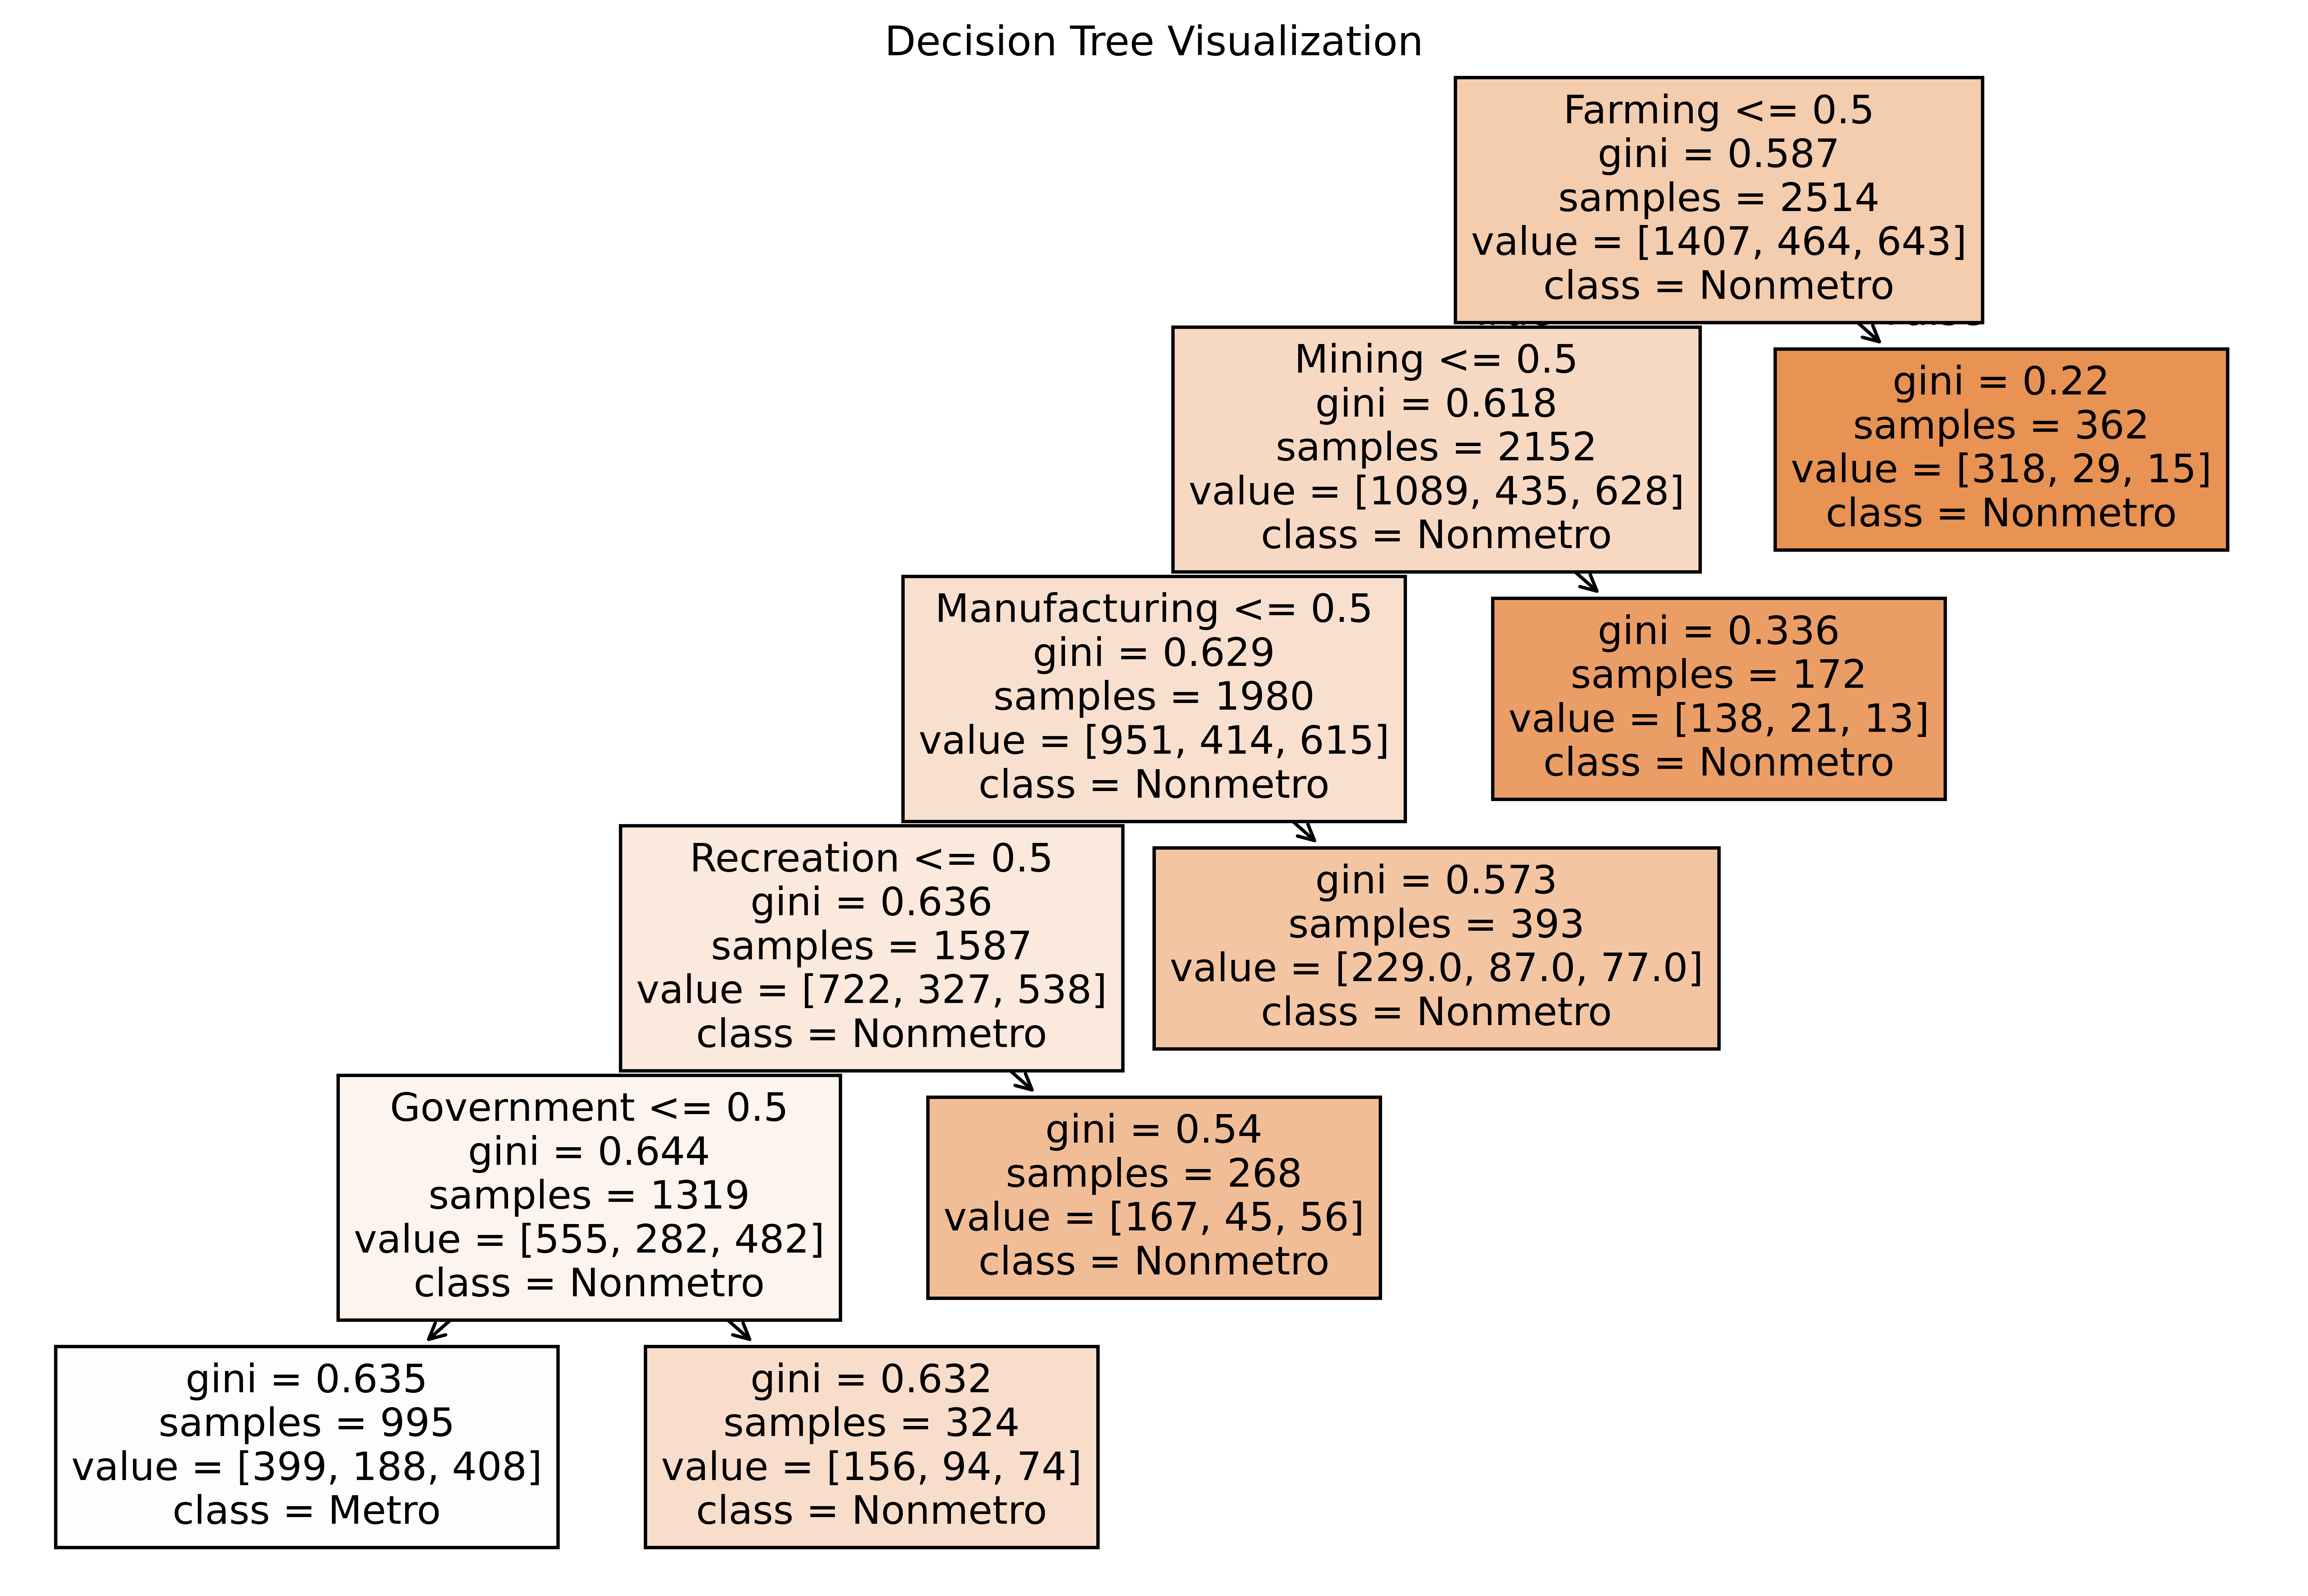

In [47]:
# Plot the decision tree
plt.figure(figsize=(12, 8), dpi=800)
plot_tree(model, feature_names=X.columns, class_names=['Nonmetro', 'Micropolitan', 'Metro'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

In [48]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature names and their importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("Feature Importances:\n", importance_df)

Feature Importances:
          Feature  Importance
0        Farming    0.506848
1         Mining    0.199280
2     Recreation    0.113775
3     Government    0.091891
4  Manufacturing    0.088206


Feature Importances:
      Feature  Importance
      Farming    0.506848
       Mining    0.199280
   Recreation    0.113775
   Government    0.091891
Manufacturing    0.088206

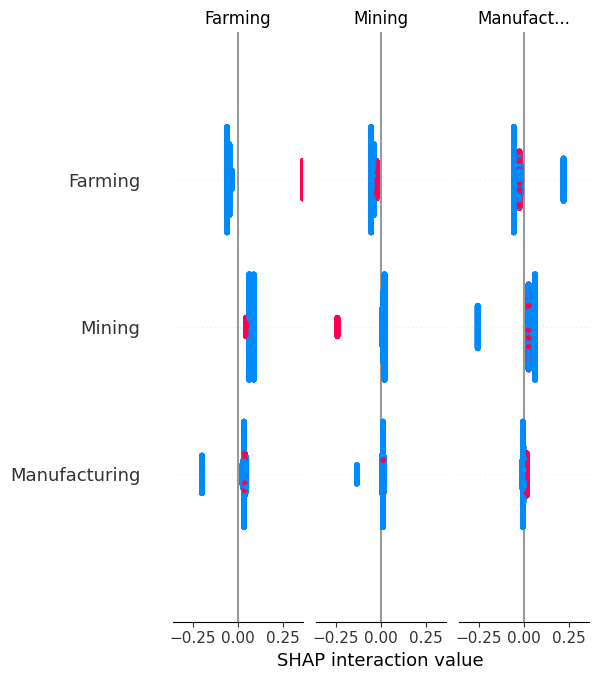

In [49]:

# Use SHAP values to interpret feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Summarize feature importance
shap.summary_plot(shap_values, X, plot_type="bar")

<Figure size 1000x1000 with 0 Axes>

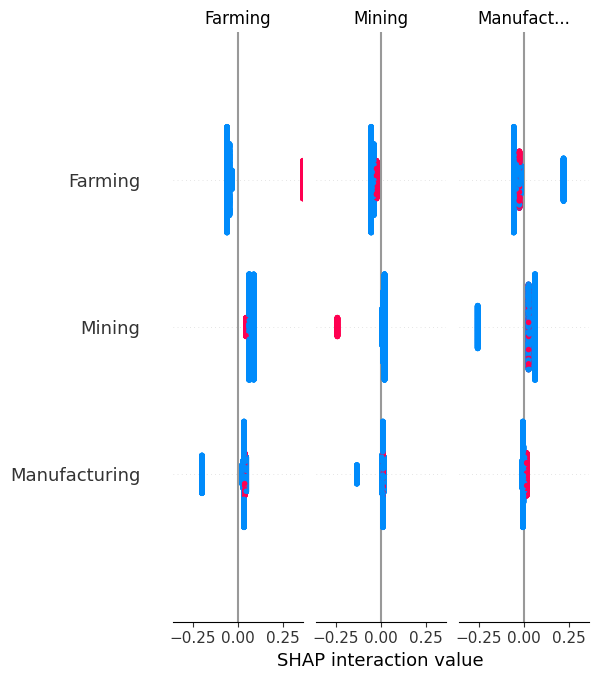

In [50]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Summarize feature importance with feature names displayed
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=X.columns)

---

In [51]:
sub_df.columns

Index(['FIPStxt', 'State', 'County', 'RuralUrbanContinuumCode2013',
       'Type_2015_Update', 'Farming', 'Manufacturing', 'Mining', 'Government',
       'Recreation', 'Low Education', 'Low Employment', 'Population Loss',
       'Retirement Destination', 'Pop_Cat', 'Category_type',
       'Encoded_Category_type'],
      dtype='object')

In [102]:
feats = ['Farming', 'Manufacturing', 'Mining', 'Government', 'Recreation', 'Retirement Destination']
X = sub_df.loc[:, feats]
y = sub_df['Population Loss']

In [103]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
# Initialize and train the decision tree classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [105]:
# test the model
model.score(X_test, y_test)

0.821939586645469

In [106]:
# build a classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90       520
         1.0       0.48      0.35      0.40       109

    accuracy                           0.82       629
   macro avg       0.68      0.63      0.65       629
weighted avg       0.80      0.82      0.81       629



In [107]:
# build a confusion matrix
confusion_matrix(y_test, y_pred)

array([[479,  41],
       [ 71,  38]], dtype=int64)

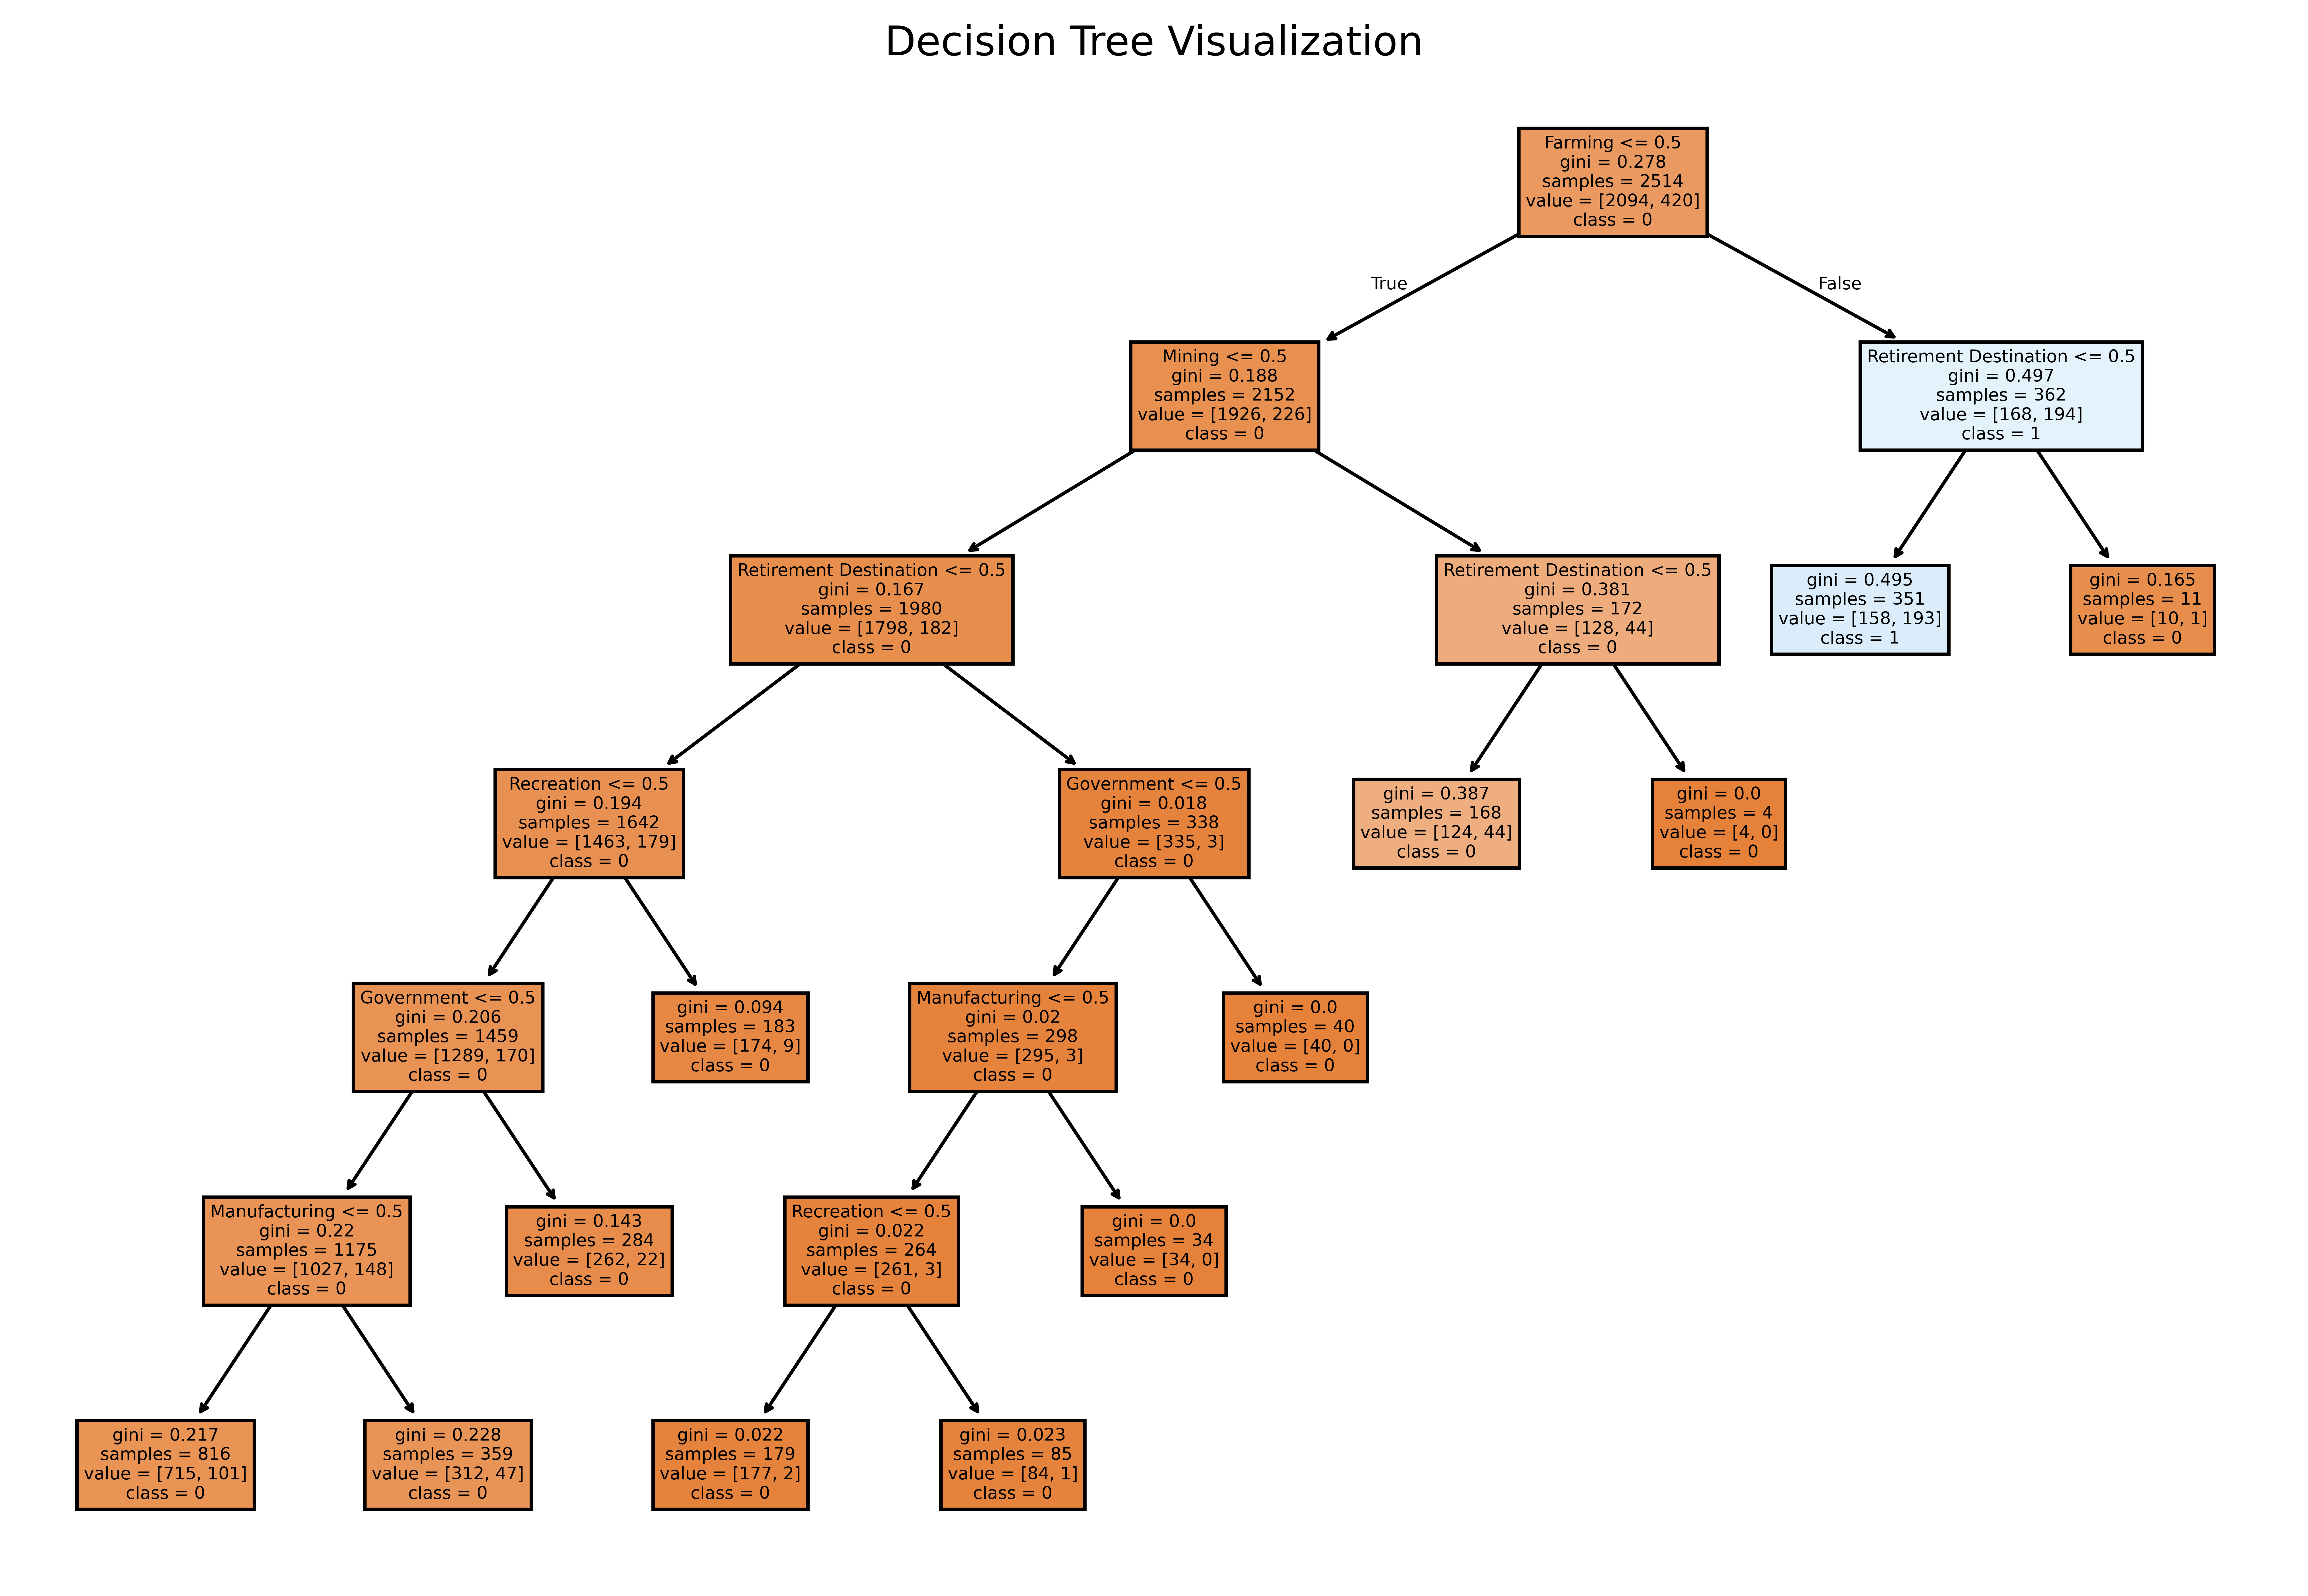

In [108]:
# Plot the decision tree
plt.figure(figsize=(12, 8), dpi=800)
plot_tree(model, feature_names=X.columns, class_names=['0', '1'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

In [109]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature names and their importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("Feature Importances:\n", importance_df)

Feature Importances:
                   Feature  Importance
0                 Farming    0.841072
1  Retirement Destination    0.077849
2                  Mining    0.062143
3              Recreation    0.010779
4              Government    0.007915
5           Manufacturing    0.000243


In [114]:
shap_values[0, :, 0].shape

(6,)

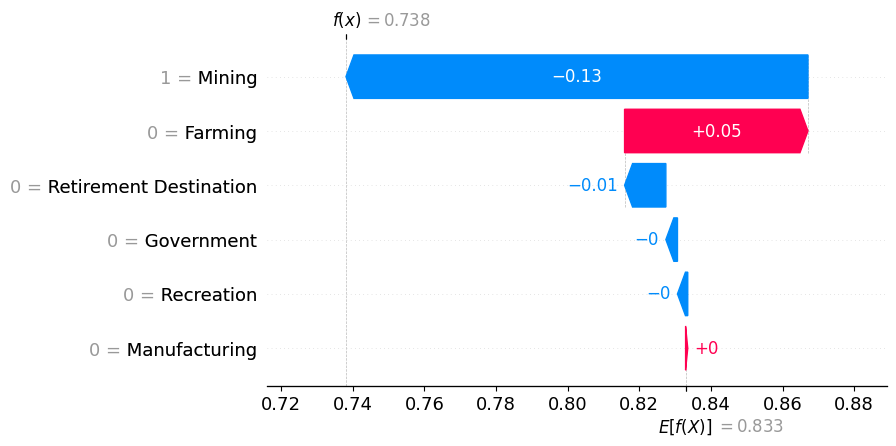

In [119]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0, :, 0])

In [120]:
y_test[0]

0.0

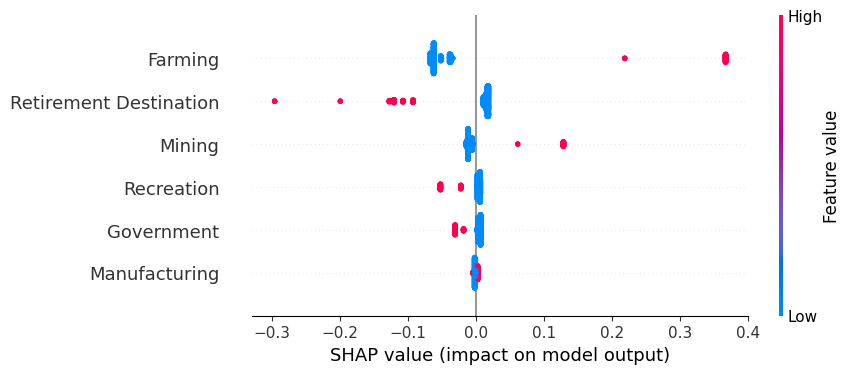

In [121]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values[:, :, 1])


In [122]:
sub_df.head()

FIPStxt State   County  RuralUrbanContinuumCode2013  Type_2015_Update  \
0     1001    AL  Autauga                          2.0               0.0   
1     1003    AL  Baldwin                          3.0               5.0   
2     1005    AL  Barbour                          6.0               3.0   
3     1007    AL     Bibb                          1.0               0.0   
4     1009    AL   Blount                          1.0               0.0   

   Farming  Manufacturing  Mining  Government  Recreation  Low Education  \
0      0.0            0.0     0.0         0.0         0.0            0.0   
1      0.0            0.0     0.0         0.0         1.0            0.0   
2      0.0            1.0     0.0         0.0         0.0            1.0   
3      0.0            0.0     0.0         0.0         0.0            1.0   
4      0.0            0.0     0.0         0.0         0.0            1.0   

   Low Employment  Population Loss  Retirement Destination       Pop_Cat  \
0             0.0              0.0                     1.0         Metro   
1             0.0              0.0                     1.0  Micropolitan   
2             1.0              0.0                     0.0      Nonmetro   
3             1.0              0.0                     0.0         Metro   
4             1.0              0.0                     0.0         Metro   

             Category_type  Encoded_Category_type  Encoded_State  
0           Nonspecialized                      2              0  
1        Recreation county                      1              0  
2  Manufacturing-dependent                      0              0  
3           Nonspecialized                      2              0  
4           Nonspecialized                      2              0

In [124]:
sub_df.loc[sub_df['Retirement Destination']==1, ['Population Loss']].value_counts()

Population Loss
0.0                436
1.0                  6
Name: count, dtype: int64

In [125]:
sub_df.loc[sub_df['Farming']==1, ['Population Loss']].value_counts()

Population Loss
1.0                232
0.0                212
Name: count, dtype: int64

---

In [78]:
# state mapping 
unique_states = sub_df['State'].unique()
state_map = {state: i for i, state in enumerate(unique_states)}
inv_state_map = {v: k for k, v in state_map.items()}

sub_df['Encoded_State'] = sub_df['State'].map(state_map)

In [95]:
feats = ['Encoded_State', 'Farming', 'Manufacturing', 'Mining', 'Government', 'Recreation', 'Retirement Destination']
X = sub_df.loc[:, feats]
y = sub_df['Population Loss']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
# Initialize and train the decision tree classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [98]:
# test the model
model.score(X_test, y_test)

0.8553259141494436

In [99]:
# build a classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92       520
         1.0       0.66      0.35      0.46       109

    accuracy                           0.86       629
   macro avg       0.77      0.66      0.69       629
weighted avg       0.84      0.86      0.84       629



In [100]:
# build a confusion matrix
confusion_matrix(y_test, y_pred)

array([[500,  20],
       [ 71,  38]], dtype=int64)

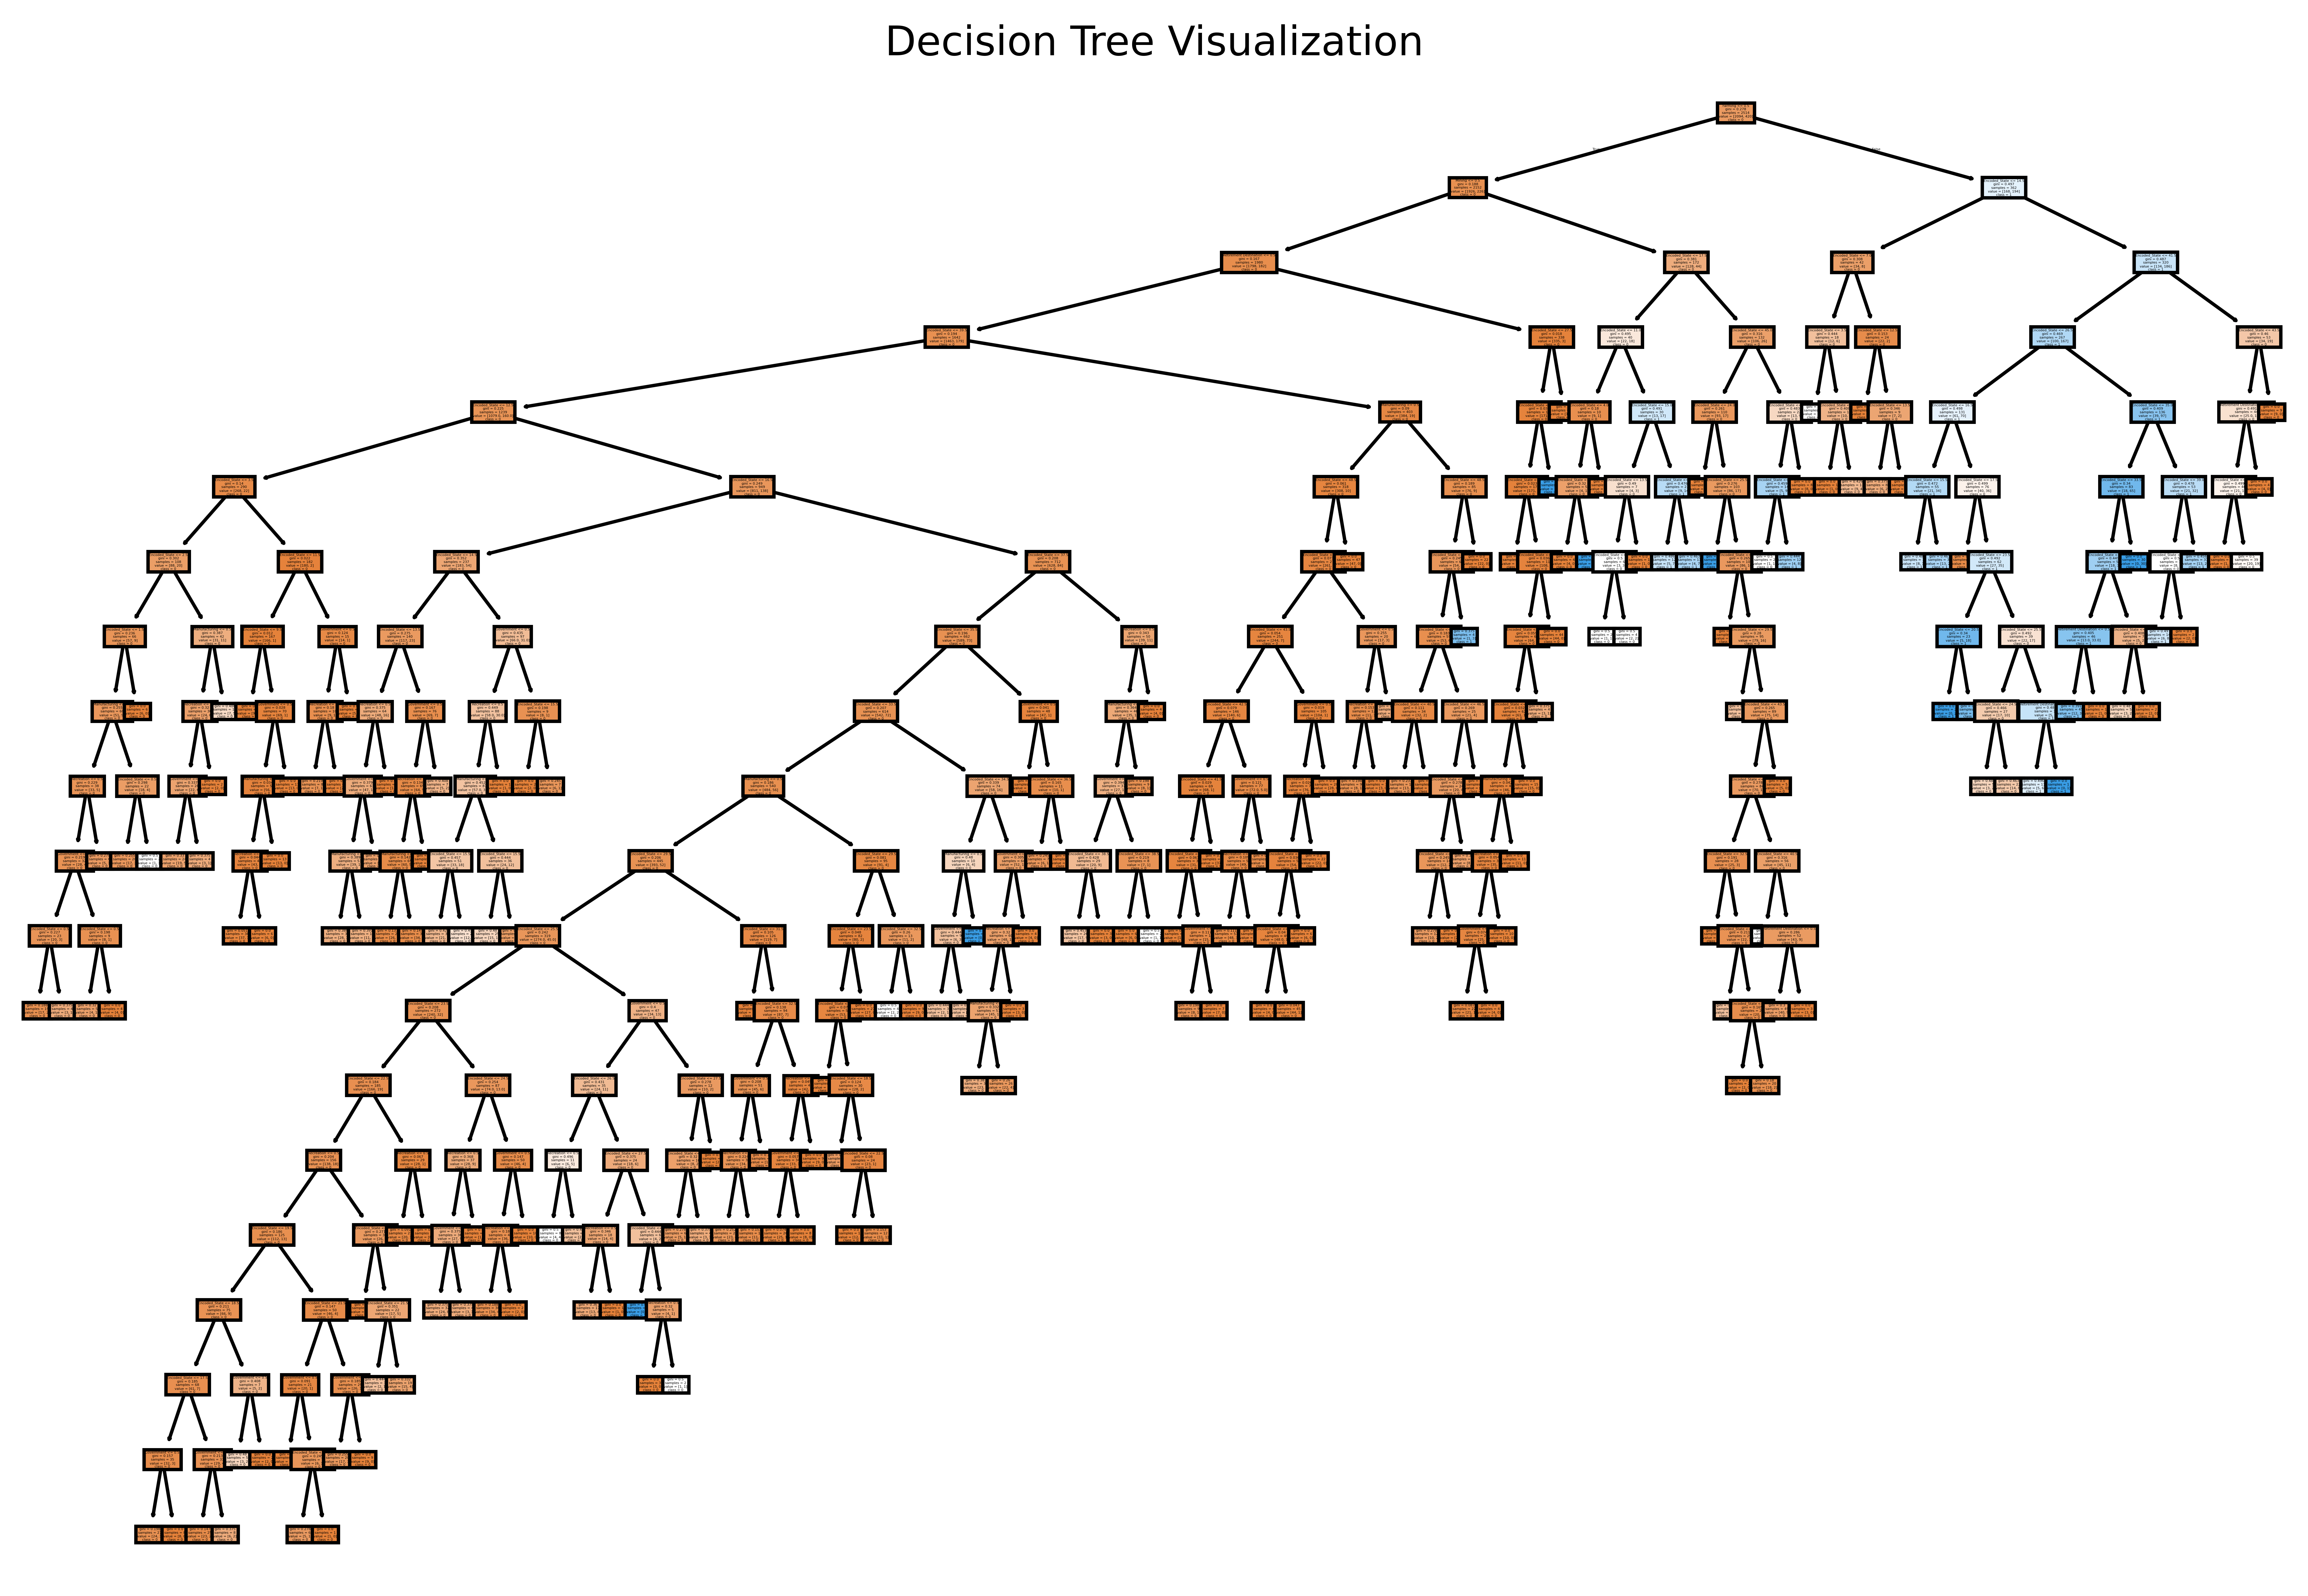

In [101]:
# Plot the decision tree
plt.figure(figsize=(12, 8), dpi=800)
plot_tree(model, feature_names=X.columns, class_names=['0', '1'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

In [91]:
import shap

In [92]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

In [94]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (7, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [77]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

In [89]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

#### Logistic Regression based feature analysis

In [30]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


In [82]:
feats = ['Farming', 'Manufacturing', 'Mining', 'Government', 'Recreation', 'Retirement Destination']
X = sub_df.loc[:, feats]
y = sub_df['Encoded_Category_type']

In [83]:

# Train Logistic Regression
model = LogisticRegression(multi_class='ovr')
model.fit(X, y)


c:\Users\nipun_qk4hy9e\miniconda3\envs\ds_env\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='ovr')

In [84]:

# Get feature importance from coefficients
feature_importance = abs(model.coef_).sum(axis=0)  # Sum across classes for multi-class
# feature_names = encoder.get_feature_names_out(['feature1', 'feature2'])

importance_df = pd.DataFrame({
    'Feature': feats,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(importance_df)


                  Feature  Importance
0                 Farming    5.629120
1                  Mining    3.891555
2              Recreation    2.036104
3           Manufacturing    1.744074
4              Government    1.619303
5  Retirement Destination    1.563420


#### PyGAM

In [85]:
from pygam import LogisticGAM, s, f
import pandas as pd


In [89]:

feats = ['Farming', 'Manufacturing', 'Mining', 'Government', 'Recreation', 'Retirement Destination']
X = sub_df.loc[:, feats]
y = sub_df['Population Loss']


In [92]:
X.columns

Index(['Farming', 'Manufacturing', 'Mining', 'Government', 'Recreation',
       'Retirement Destination'],
      dtype='object')

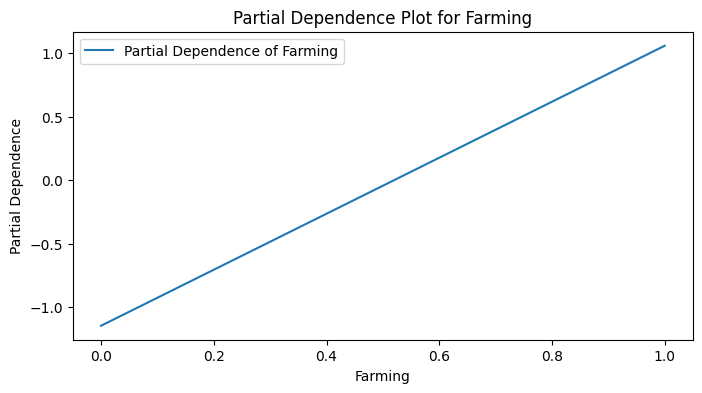

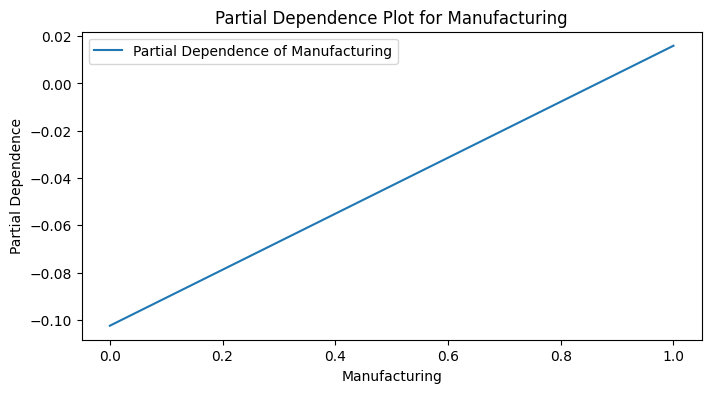

In [96]:

# Train a GAM model
gam = LogisticGAM(s(0) + s(1)).fit(X, y)

# Plot partial dependence for each feature, excluding the intercept
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue  # Skip intercept term

    # Generate grid for the term and calculate partial dependence
    XX = gam.generate_X_grid(term=i)
    partial_dep = gam.partial_dependence(term=i, X=XX)

    # Plot the partial dependence for the feature
    plt.figure(figsize=(8, 4))
    plt.plot(XX[:, i], partial_dep, label=f'Partial Dependence of {X.columns[i]}')
    plt.xlabel(X.columns[i])
    plt.ylabel("Partial Dependence")
    plt.title(f"Partial Dependence Plot for {X.columns[i]}")
    plt.legend()
    plt.show()
